X shape: (11690, 38)  | y shape: (11690,)
Accuracy: 0.6381522668947819
Precision: 0.6344712739383847
Recall: 0.6518391787852865
F1 Score: 0.6430379746835442
ROC AUC: 0.6878368400678784

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.62      0.63      1169
           1       0.63      0.65      0.64      1169

    accuracy                           0.64      2338
   macro avg       0.64      0.64      0.64      2338
weighted avg       0.64      0.64      0.64      2338



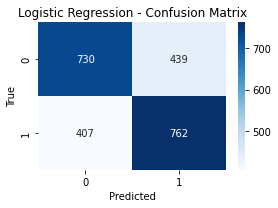

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------
# Load pre-engineered data
# ------------------------
X = np.load("nba_fe_outputs/X_game.npy")
y = np.load("nba_fe_outputs/y_game.npy")

print("X shape:", X.shape, " | y shape:", y.shape)

# ------------------------
# Train/Test split
# ------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ------------------------
# Scale + Train Logistic Regression
# ------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)
clf.fit(X_train_scaled, y_train)

# ------------------------
# Evaluate
# ------------------------
y_proba = clf.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ------------------------
# Confusion Matrix
# ------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
